In [1]:
# Dependencies
!git clone https://github.com/openai/CLIP
!pip install kornia
!pip install ftfy regex tqdm omegaconf pytorch-lightning
!pip install kornia
!pip install imageio-ffmpeg   
!pip install einops
!pip install gdown

fatal: destination path 'CLIP' already exists and is not an empty directory.


In [2]:
# import packages
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import transforms
from torchvision.transforms import functional as TF
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from tqdm.notebook import tqdm
from CLIP import clip
import kornia.augmentation as K
import numpy as np
import imageio
from PIL import ImageFile, Image
import seaborn as sns
import matplotlib.pyplot as plt
import urllib.request
import os
import collections
import seaborn as sns
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
# load clip model
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
clip_model, preprocess = clip.load('ViT-B/32', jit=False)
clip_model = clip_model.eval().requires_grad_(False).to(device)

In [5]:
# Download the fairface dataset (we only use the valdation part data)
!gdown 1Z1RqRo0_JiavaZw2yzZG6WETdZQ8qX86
!unzip ./fairface-img-margin025-trainval.zip

# download the fairface labels
!gdown 1wOdja-ezstMEp81tX1a-EYkFebev4h7D

Downloading...
From: https://drive.google.com/uc?id=1Z1RqRo0_JiavaZw2yzZG6WETdZQ8qX86
To: /content/fairface-img-margin025-trainval.zip
100% 578M/578M [00:01<00:00, 289MB/s]
Archive:  ./fairface-img-margin025-trainval.zip
replace train/1346.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: Downloading...
From: https://drive.google.com/uc?id=1wOdja-ezstMEp81tX1a-EYkFebev4h7D
To: /content/fairface_label_val.csv
100% 448k/448k [00:00<00:00, 137MB/s]


In [4]:
# Sanity check on the label csv
label_csv = pd.read_csv('fairface_label_val.csv')
races = label_csv['race'].unique().tolist()
genders = label_csv['gender'].unique().tolist()
ages = label_csv['age'].unique().tolist()

In [5]:
race2idx = {r: i for i, r in enumerate(races)}
gender2idx = {g: i for i, g in enumerate(genders)}
age2idx = {a: i for i, a in enumerate(ages)}

In [6]:
class FairFace(Dataset):
  def __init__(self, image_dir, df):
    super(FairFace, self).__init__()
    self.ages = [age2idx[a] for a in df['age']]
    self.genders = [gender2idx[g] for g in df['gender']]
    self.races = [race2idx[r] for r in df['race']]
    self.images = df['file']
    self.image_dir = image_dir

  def __getitem__(self, index):
    # print(os.path.join(self.image_dir, self.images[index]))
    img = Image.open(os.path.join(self.image_dir, self.images[index]))
    img = preprocess(img)
    race = torch.tensor(self.races[index]).long()
    gender = torch.tensor(self.genders[index]).long()
    age = torch.tensor(self.ages[index]).long()
    return img, race, gender, age

  def __len__(self):
    return len(self.races)

In [7]:
fairface = FairFace('.', label_csv)
fairface_loader = DataLoader(fairface, batch_size=12, shuffle=False)

In [9]:
# get bad word list
!wget -c -O bad-words.txt https://www.cs.cmu.edu/~biglou/resources/bad-words.txt

--2022-04-23 02:21:39--  https://www.cs.cmu.edu/~biglou/resources/bad-words.txt
Resolving www.cs.cmu.edu (www.cs.cmu.edu)... 128.2.42.95
Connecting to www.cs.cmu.edu (www.cs.cmu.edu)|128.2.42.95|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [10]:
badwords = []
with open('bad-words.txt', 'r') as f:
  for line in f:
    badwords.append(line[:-1])

In [11]:
class CLIPBadWordsDetector:
  def __init__(self, clip_encoder, dataloader, text_source):
    super().__init__()
    self.clip_encoder = clip_encoder
    self.dataloader = dataloader
    self.text = text_source
    self.text_embedding = F.normalize(self.clip_encoder.encode_text(clip.tokenize(self.text).to(device)))

  def test_all_images(self):
    similarities = []
    for img, race, gender, age in tqdm(fairface_loader):
      img = img.to(device)
      img_embedding = clip_model.encode_image(img)
      img_embedding = F.normalize(img_embedding, dim=1)
      cos_sim = img_embedding @ self.text_embedding.T # [bs, num_words]
      similarities.append(cos_sim.mean(dim=1))
    similarities = torch.cat(similarities).cpu().numpy()
    return similarities

In [12]:
detector = CLIPBadWordsDetector(clip_model, fairface_loader, badwords)
mean_dist = detector.test_all_images()

  0%|          | 0/913 [00:00<?, ?it/s]

In [13]:
label_csv['MCSBW'] = mean_dist
label_csv = label_csv.sort_values(by=['age'])

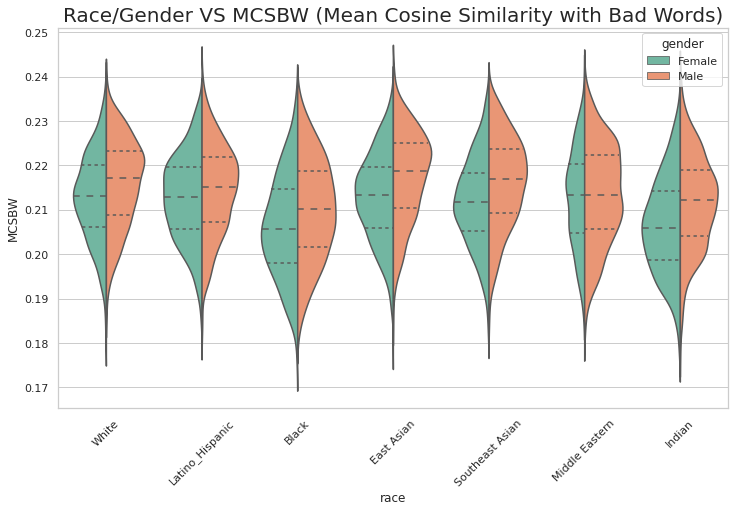

In [14]:
sns.set(style='whitegrid', palette='Set2')

plt.figure(figsize=(12, 7))
sns.violinplot(data=label_csv, x='race', y='MCSBW', hue='gender', split=True, scale='count', inner='quartile')
plt.xticks(rotation=45)
plt.title('Race/Gender VS MCSBW (Mean Cosine Similarity with Bad Words)', fontsize=20)
plt.show()

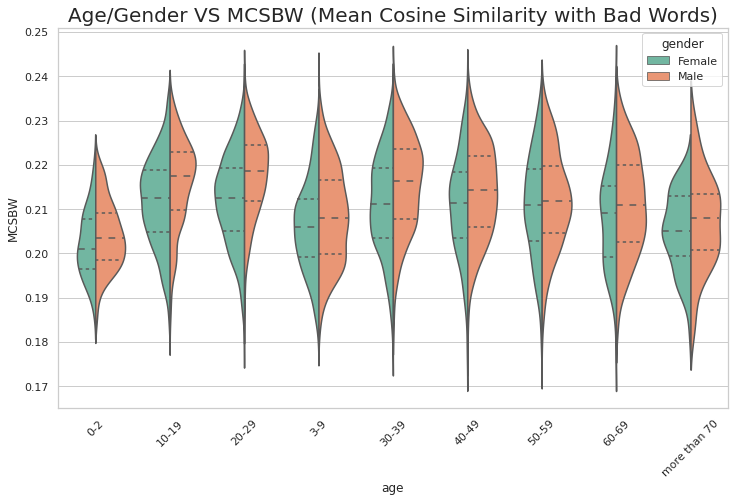

In [15]:
plt.figure(figsize=(12, 7))
sns.violinplot(data=label_csv, x='age', y='MCSBW', hue='gender', split=True, scale='count', inner='quartile')
plt.xticks(rotation=45)
plt.title('Age/Gender VS MCSBW (Mean Cosine Similarity with Bad Words)', fontsize=20)
plt.show()

In [16]:
label_csv.to_csv('mean_cos_sim.csv')